### Calculate wind profiles for various supply regions using WASA data points 

In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import atlite
import numpy as np
from shapely.ops import voronoi_diagram, nearest_points
from shapely.geometry import MultiPoint, Point
import xarray as xr
from scipy.interpolate import griddata
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

from _helpers import(
    load_gis_data,
    load_turbine_power_curves,
    generate_wind_timeseries,
    aggregate_intra_region,
    calculate_voronoi_for_supply_region,
    select_intra_region_voronoi,
    calc_wasa_timeseries,
)

# Load Data

In [3]:
# data_bundle_path = "../../data/bundle"


# regions={}
# for r in [1, 10, 27, 34, 159]:
#     regions[r] = gpd.read_file(f"{data_bundle_path}/rsa_supply_regions.gpkg", layer = str(r))
#     regions[r] = regions[r].to_crs("EPSG:4326")

# regions[10]["name"] = regions[10]["SupplyArea"]
# regions[34]["name"] = regions[34]["LocalArea"]
# regions[159]["name"] = regions[159]["MTS_1"]

# turbine_power_curves = pd.read_csv('../../data/turbine_power_curves.csv',index_col=0)
# cutout = atlite.Cutout('../../cutouts/RSA-2010_22-era5.nc')

# wasa_gps = pd.read_csv('../../data/wasa_gps.csv')
# wasa_gps = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude))

# wasa_gps = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude))
# wasa_gps.crs = 'EPSG:4326'
# wasa_gps = gpd.sjoin(wasa_gps, gis_data["supply_regions"][34], how="inner", op='intersects')
# wasa_gps = wasa_gps.drop(columns=['index_right'])



# eia_regions = gpd.read_file(f"{data_bundle_path}/REEA_OR_2023_Q3.shp")
# eia_regions = eia_regions[eia_regions["TECHNOLOGY"].isin(["Wind", "Solar PV", "Wind and Solar PV"])]

# redz1 = gpd.read_file(f"{data_bundle_path}/REDZs.shp").to_crs("EPSG:4326")
# redz2 = gpd.read_file(f"{data_bundle_path}/PHASE 2_REDZs.shp").to_crs("EPSG:4326")
# redz = pd.concat([redz1, redz2], ignore_index=True)
# redz.to_crs("EPSG:4326", inplace=True)
# eia_regions.to_crs("EPSG:4326", inplace=True)

# corridors = gpd.read_file(f"{data_bundle_path}/Power_corridors.shp")
# corridors.to_crs("EPSG:4326", inplace=True)

# redz_corridors_eia = pd.concat([redz, corridors, eia_regions], ignore_index=True)

# sacad = gpd.read_file(f"{data_bundle_path}/SACAD_OR_2023_Q3.shp")
# sacad.to_crs("EPSG:4326", inplace=True)

# sapad = gpd.read_file(f"{data_bundle_path}/SAPAD_OR_2023_Q3.shp")
# sapad.to_crs("EPSG:4326", inplace=True)

# sacpad = pd.concat([sacad, sapad], ignore_index=True) # combined sacad and sapad zones
# sacpad.to_crs("EPSG:4326", inplace=True)

# ska = gpd.read_file(f"{data_bundle_path}/SKA/SKA_exclusion.shp")
# ska.to_crs("EPSG:4326", inplace=True)

# sacpad_ska = pd.concat([sacpad, ska], ignore_index=True) # combined sacpad and sapad zones

# gis_data = {
#     "eia_regions": eia_regions,
#     "redz": redz,
#     "corridors": corridors,
#     "redz_corridors_eia": redz_corridors_eia,
#     "sacpad": sacpad,
#     "ska": ska,
#     "data_bundle_path": data_bundle_path
# }

In [4]:
data_bundle_path = "../../data/bundle"
gis_data = load_gis_data(data_bundle_path)

Loading Eskom Supply Regions from ../../data/bundle/rsa_supply_regions.gpkg
Loading EIA applications from ../../data/bundle/REEA_OR_2023_Q3.shp
Loading REDZs from ../../data/bundle/REDZs.shp
Loading Power Corridors from ../../data/bundle/Power_corridors.shp
Loading SACAD from ../../data/bundle/SACAD_OR_2023_Q3.shp
Loading SAPAD from ../../data/bundle/SAPAD_OR_2023_Q3.shp
Loading SKA exclusion from ../../data/bundle/SKA/SKA_exclusion.shp


In [5]:
wasa_gps = pd.read_csv('../../data/weather/wasa_gps.csv')
wasa_gps = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude))

wasa_gps = gpd.GeoDataFrame(wasa_gps, geometry=gpd.points_from_xy(wasa_gps.Longitude, wasa_gps.Latitude))
wasa_gps.crs = 'EPSG:4326'
wasa_gps = gpd.sjoin(wasa_gps, gis_data["supply_regions"][34], how="inner", op='intersects')
wasa_gps = wasa_gps.drop(columns=['index_right'])

for i in wasa_gps.index:
    wasa_gps.loc[i, "cleaned_file_name"] = wasa_gps.loc[i, "file_name"].replace(".csv","")

In [6]:
turbine_power_curves = pd.read_csv('../../data/turbine_power_curves.csv',index_col=0)
cutout = atlite.Cutout('../../cutouts/RSA-2010_22-era5.nc')

<Axes: >

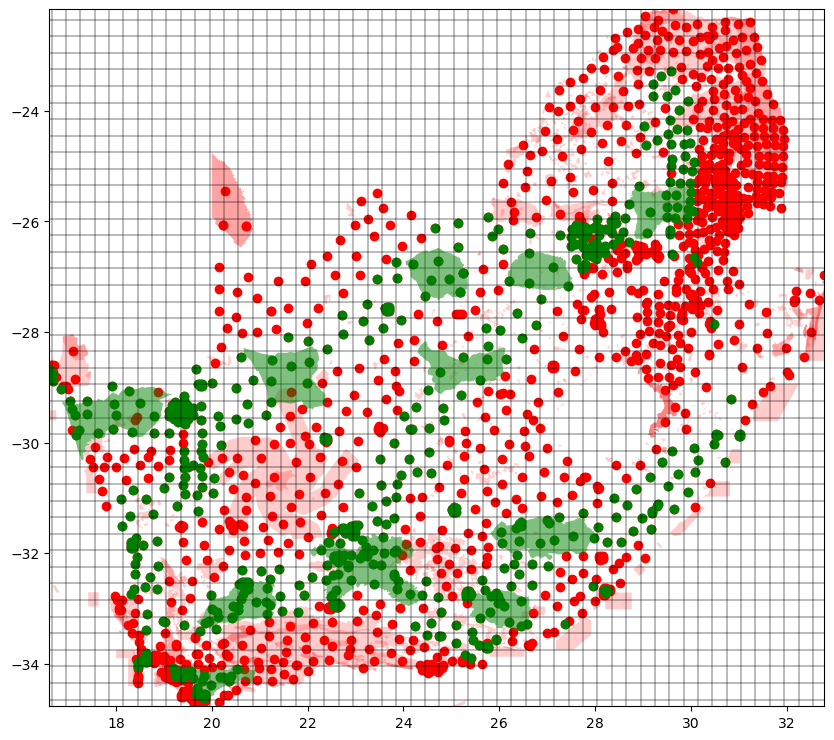

In [7]:
def filter_wasa_points(wasa, filter=None, bus=None, by="exclude"):
    if bus is not None:
        return wasa[wasa.within(bus.geometry.unary_union)].reset_index(drop=True)
    intersect = gpd.sjoin(wasa, filter, how="inner", op='intersects')
    intersect = intersect.drop(columns=['index_right'])
    intersect = intersect['cleaned_file_name'].unique()
    if by == "include":
        return wasa[wasa['cleaned_file_name'].isin(intersect)]
    elif by == "exclude":
        return wasa[~wasa['cleaned_file_name'].isin(intersect)]
    
wasa_gps_cleaned = filter_wasa_points(wasa_gps, gis_data["exclusion"], by ="exclude")

filtered_wasa_gps = {
    "all" : wasa_gps_cleaned,
    "redz" : filter_wasa_points(wasa_gps_cleaned, gis_data["redz"], by = "include"), 
    "corridors" : filter_wasa_points(wasa_gps_cleaned, gis_data["corridors"], by ="include"), 
    "redz_corridors_eia" : filter_wasa_points(wasa_gps_cleaned, gis_data["redz_corridors_eia"], by = "include"), 
}

fig, ax=plt.subplots(figsize=(10,10))
gis_data["exclusion"].plot(ax=ax, color='r', alpha=0.2)
wasa_gps.plot(ax=ax,color='r')
filtered_wasa_gps["redz_corridors_eia"].plot(ax=ax, color='g')
cutout.grid.plot(ax=ax, facecolor='None', lw=0.2)

ax.set_xlim(wasa_gps.total_bounds[0], wasa_gps.total_bounds[2])
ax.set_ylim(wasa_gps.total_bounds[1], wasa_gps.total_bounds[3])

gis_data["redz"].plot(ax=ax, color='g', alpha=0.5)

# Extract WASA timeseries

In [8]:
def wind_power_calc(data, power_curve, turbine_class):
    return np.interp(data, power_curve.index, power_curve[f"Class {turbine_class}"].values)

In [9]:
all_wasa_files = wasa_gps['cleaned_file_name']
raw_date_range = pd.date_range("1990-01-01 00:00", "2019-12-31 23:30", freq='H')
date_range = pd.date_range("2010-01-01 00:00", "2019-12-31 23:30", freq='H')

wasa_pu = pd.DataFrame(0, index=date_range, columns=all_wasa_files)
wasa_ws = pd.Series(index=all_wasa_files)
wasa_turb_class = pd.Series(index=all_wasa_files)

file_path = '../../data/weather/WASA weather files'

def process_file(f):
    try:
        wind_data = pd.read_csv(os.path.join(file_path, f), index_col=0, skiprows=8, parse_dates=True).resample('H').mean()
        wind_speed = wind_data[['S60', 'S100', 'S120', 'S160']].rename(columns={'S60': 60, 'S100': 100, 'S120': 120, 'S160': 160})
        wind_speed[80] = np.nan
        wind_speed[140] = np.nan
        wind_speed = wind_speed.interpolate(axis=0).interpolate(axis=1)
        
        avg_spd = wind_speed.mean()
        if avg_spd[80] > 8.5:
            turbine_class = 1
            hub_height = 80
        elif (avg_spd[80] < 8.5) & (avg_spd[100] > 7.5):
            turbine_class = 2
            hub_height = 80
        elif (avg_spd[100] < 7.5) & (avg_spd[100] > 6):
            turbine_class = 3
            hub_height = 100
        elif (avg_spd[120] < 7.5) & (avg_spd[120] > 6):
            turbine_class = 3
            hub_height = 120
        else:
            turbine_class = 3
            hub_height = 140

        wp = pd.Series(wind_power_calc(wind_speed[hub_height], turbine_power_curves, turbine_class), index=raw_date_range)
        
        return f.split('.csv')[0], avg_spd[hub_height], turbine_class, wp.loc[wasa_pu.index].values
    except Exception as e:
        print(f"Error processing file {f}: {e}")
        return None

files_to_process = [f for root, dirs, files in os.walk(file_path) for f in files]

with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(process_file, files_to_process), total=len(files_to_process)))

for result in results:
    if result is not None:
        file_name, avg_speed, turbine_class, wp_values = result
        wasa_ws[file_name] = avg_speed
        wasa_pu[file_name] = wp_values
        wasa_turb_class[file_name] = turbine_class

# save wasa_pu to netcdf
wasa_pu = xr.DataArray(wasa_pu.values, coords=[date_range, wasa_pu.columns], dims=['time', 'location'])
wasa_pu.to_netcdf('timeseries_data/wasa_profiles.nc')


 52%|█████▏    | 1031/2001 [09:25<14:18,  1.13it/s]

Error processing file lat-28.2618_lon25.7564.csv: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'


100%|██████████| 2001/2001 [18:26<00:00,  1.81it/s]
